In [ ]:
#作業重點:
#(1)以, Adam, 為例, 調整 batch_size, epoch , 觀察accurancy, loss 的變化

#(2)以同一模型, 分別驗證 SGD, Adam, Rmsprop 的 accurancy

#作業目標:
#取得各種優化器的運算結果

In [1]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os
from keras import optimizers

Using TensorFlow backend.


In [2]:
#Blas GEMM launch failed , 避免動態分配GPU / CPU, 出現問題
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [4]:
'''
   宣告並設定
   batch_size：對總的樣本數進行分組，每組包含的樣本數量
   epochs ：訓練次數
   
''' 
batch_size = 32
#batch_size = 32
num_classes = 10 # 影像類別數
epochs = 20 #1个epoch表示过了1遍训练集中的所有样本。
data_augmentation = True #数据增强变换
num_predictions = 20 #預測
save_dir = os.path.join(os.getcwd(), 'saved_models') #os.path.join(os.getcwd()就是获取当前目录，并组合成新目
model_name = 'keras_cifar10_trained_model.h5'## 模型名称，用.h5保存

In [5]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices. # Convert class vectors to binary class matrices. #＃將類向量轉換為二進制類矩陣。
y_train = keras.utils.to_categorical(y_train, num_classes)#keras.utils.to_categorical函數：是把類別標籤轉換爲onehot編碼（categorical就是類別標籤的意思，表示現實世界中你分類的各類別）， 而onehot編碼是一種方便計算機處理的二元編碼。**
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [6]:
#    第一步：選擇模型, 順序模型是多個網絡層的線性堆疊
 
model = Sequential()#sequential model就是那种最简单的结构的模型。按顺序一层一层训练，一层一层往前的那种。没有什么环的结构。比如像前馈网络那样。

#   第二步：構建網絡層
model.add(Conv2D(32, (3, 3), padding='same', ##邊界模式=same (填補=0, 步幅=1)
                 input_shape=x_train.shape[1:])) # _shape 形狀
model.add(Activation('relu')) ## 将激活函数sigmoid改为ReLU
model.add(Conv2D(32, (3, 3)))#二維 #pool_size: 整数，或者 2 个整数表示的元组， 沿（垂直，水平）方向缩小比例的因数。 （2，2）会把输入张量的两个维度都缩小一半。 如果只使用一个整数，那么两个维度都会使用同样的窗口长度。
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25)) #Dropout的意思是：每次训练时随机忽略一部分神经元，这些神经元dropped-out了。换句话讲，这些神经元在正向传播时对下游的启动影响被忽略，反向传播时也不会更新权重。

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) #flatten是numpy.ndarray.flatten的一個函數，即返回一個一維數組。
model.add(Dense(512)) ##Dense就是常用的全连接层，所实现的运算是output = activation(dot(input, kernel)+bias)。其中activation是逐元素计算的激活函数，kernel`是本层的权值矩阵，bias为偏置向量，只有当use_bias=True才会添加。
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense( 10)) # 輸出結果是10個類別，所以維度是10   
model.add(Activation('softmax')) # 最後一層用softmax作為激活函數

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
# 模型建立完成後，統計參數總量
print("Total Parameters：%d" % model.count_params())

Total Parameters：1250858


In [8]:
# 輸出模型摘要資訊
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
__________

In [15]:
#第三步編譯
'''
 SGD(隨機梯度下降) - Arguments
lr: float >= 0. Learning rate.
momentum: float >= 0. Parameter that accelerates SGD in the relevant direction and dampens oscillations.
decay: float >= 0. Learning rate decay over each update.
nesterov: boolean. Whether to apply Nesterov momentum.

RMSprop- Arguments
lr: float >= 0. Learning rate.
rho: float >= 0.
epsilon: float >= 0. Fuzz factor. If None, defaults to K.epsilon().
decay: float >= 0. Learning rate decay over each update.

Example:
opt = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
SGD（隨機梯度下降） - 參數
lr：float> = 0.學習率。
動量：float> = 0.參數可以加速相關方向的SGD並抑制振盪。
衰減：浮動> = 0.每次更新時學習率下降。
nesterov：布爾值。 是否適用Nesterov勢頭。

RMSprop-參數
lr：float> = 0.學習率。
rho：float> = 0。
epsilon：float> = 0.模糊因子。 如果為None，則默認為K.epsilon（）。
衰減：浮動> = 0.每次更新時學習率下降。

例：
opt = optimizers.SGD（lr = 0.01，衰減= 1e-6，動量= 0.9，nesterov = True）

'''
#model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.compile(optimizer = 'SGD', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [16]:
# 資料正規化
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [22]:
# 是否要做資料處理
if not data_augmentation:
    print('Not using data augmentation.')
    history=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
    #形式为（X，y）或（X，y，sample_weights）的tuple，是指定的验证集。此参数将覆盖validation_spilt。
    #Model.fit(训练集x ,  训练集y)     #模型训练
    #布尔值或字符串，一般为布尔值，表示是否在训练过程中随机打乱输入样本的顺序。若为字符串“batch”，则是用来处理HDF5数据的特殊情况，它将在batch内部将数据打乱。
else:
    print('Using real-time data augmentation.')
    print('')
        
    # This will do preprocessing and realtime data augmentation: 這將進行預處理和實時數據擴充：
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset ＃在數據集上設置輸入均值為0
        samplewise_center=False,  # set each sample mean to 0 ＃將每個樣本均值設置為0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset  按數據集的標準劃分輸入
        samplewise_std_normalization=False,  # divide each input by its std＃按數據集的std劃分輸入
        zca_whitening=False,  # apply ZCA whitening # apply ZCA whitening #appin ZCA美白 資料白化（Whitening）處理：提供ZCA Whitening處理。（Whitening是一種將資料去冗餘的技術）
        zca_epsilon=1e-06,  # epsilon for ZCA whitening # epsilon for ZCA whitening 用於ZCA美白的epsilon 小量
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180) 隨機旋轉範圍內的圖像（度，0到180）
        # randomly shift images horizontally (fraction of total width) 水平隨機移動圖像（總寬度的一部分）
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height) ＃垂直隨機移動圖像（總高度的分數）
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear ＃隨機剪切的設定範圍
        zoom_range=0.,  # set range for random zoom ＃設置隨機縮放的範圍
        channel_shift_range=0.,  # set range for random channel shifts 設置隨機頻道切換的範圍
        # set mode for filling points outside the input boundaries 模式用於填充輸入邊界之外的點
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant" value用於fill_mode =“常數”
        horizontal_flip=True,  # randomly flip images ＃隨機翻轉圖像 horizontal_fli橫
        vertical_flip=False,  # randomly flip images  垂直
        # set rescaling factor (applied before any other transformation) 設置重新縮放因子（在任何其他轉換之前應用）
        rescale=None,
        # set function that will be applied on each input 函數將應用於每個輸入
        preprocessing_function=None, #預處理功能=無
        # image data format, either "channels_first" or "channels_last"  圖像數據格式，通道首先或通道最後
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)  保留用於驗證的圖像分數（嚴格在0和1之間）
        validation_split=0.0)  #validation_split：0~1之间的浮点数，用来指定训练集的一定比例数据作为验证集。验证集将不参与训练，并在每个epoch结束后测试的模型的指标，如损失函数、

    # Compute quantities required for feature-wise normalization 計算特徵標準化所需的數量
    # (std, mean, and principal components if ZCA whitening is applied). 如果應用ZCA白化，則為std，mean和主要組件）。
    datagen.fit(x_train)
    history=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)   

'''
   第四步：訓練
   .fit的一些參數
   batch_size：對總的樣本數進行分組，每組包含的樣本數量
   epochs ：訓練次數
   shuffle：是否把數據隨機打亂之後再進行訓練
   validation_split：拿出百分之多少用來做交叉驗證
   verbose：屏顯模式 - 0：不輸出, 1：輸出進度, 2：輸出每次的訓練結果
''' 

Using real-time data augmentation.

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 385s 8ms/step - loss: 2.0811 - acc: 0.2281 - val_loss: 1.8735 - val_acc: 0.3356
Epoch 2/20
50000/50000 [==============================] - 375s 7ms/step - loss: 1.7895 - acc: 0.3472 - val_loss: 1.6107 - val_acc: 0.4201
Epoch 3/20
50000/50000 [==============================] - 373s 7ms/step - loss: 1.6206 - acc: 0.4088 - val_loss: 1.4874 - val_acc: 0.4599
Epoch 4/20
50000/50000 [==============================] - 375s 7ms/step - loss: 1.4952 - acc: 0.4586 - val_loss: 1.3887 - val_acc: 0.4960
Epoch 5/20
50000/50000 [==============================] - 377s 8ms/step - loss: 1.3963 - acc: 0.4983 - val_loss: 1.2597 - val_acc: 0.5543
Epoch 6/20
50000/50000 [==============================] - 378s 8ms/step - loss: 1.3220 - acc: 0.5294 - val_loss: 1.1941 - val_acc: 0.5762
Epoch 7/20
50000/50000 [==============================] - 398s 8ms/step - loss: 1.2530

'\n   第四步：訓練\n   .fit的一些參數\n   batch_size：對總的樣本數進行分組，每組包含的樣本數量\n   epochs ：訓練次數\n   shuffle：是否把數據隨機打亂之後再進行訓練\n   validation_split：拿出百分之多少用來做交叉驗證\n   verbose：屏顯模式 - 0：不輸出, 1：輸出進度, 2：輸出每次的訓練結果\n'

In [23]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Saved trained model at C:\Users\administrator\saved_models\keras_cifar10_trained_model.h5 
10000/10000 [==============================] - 23s 2ms/step
Test loss: 0.7532139462471008
Test accuracy: 0.7424


In [26]:
#    第六步：輸出
import numpy 

print ( " test set " )
scores = model.evaluate(x_test,y_test,batch_size=200,verbose= 1) #evaluate 評估 batch批次
print ( "" )
#print ( " The test loss is %f " % scores) 
print ( " The test loss is %f ", scores) # %f 將浮點 數以10進位方式輸出


result = model.predict(x_test,batch_size=200,verbose= 0)# predict 預測

result_max = numpy.argmax(result, axis = 1 ) #numpy.argmax 返回沿轴axis最大值的索引。 result 結果 numpy中axis=0表示列，axis=1表示行。
test_max = numpy.argmax(y_test, axis = 1 )

result_bool = numpy.equal(result_max, test_max) #numpy.equal 等於的意思
true_num = numpy.sum(result_bool) #距陣相加的意思

 test set 
10000/10000 [==============================] - 21s 2ms/step

 The test loss is %f  [0.7532139360904694, 0.7424000024795532]


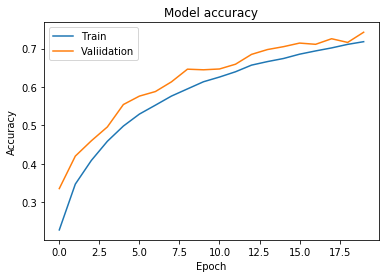

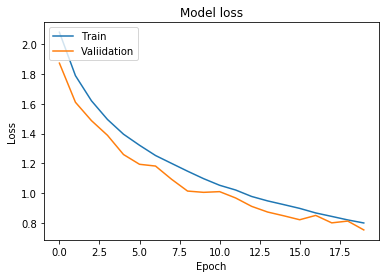

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot training & validation accuracy values ＃繪製培訓和驗證準確度值
plt.plot(history.history['acc']) #一个 History 对象。其 History.history 属性是连续 epoch 训练损失和评估值，以及验证集损失和评估值的记录（如果适用）
plt.plot(history.history['val_acc'])
'''
acc: 模型在训练集上准确率
loss: 模型在训练集上的代价函数值
val_acc: 模型在验证集上准确率
val_loss: 模型在验证集上的代价函数值
'''
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valiidation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valiidation'], loc='upper left')
plt.show()